# Dam detection

First iteration of dam detection using Sentinel 2 satellite images and GRanD dam dataset.
The code is inspired by work from a previous [hackathon](https://medium.com/@charlotteweil/can-we-locate-dams-from-space-2a796ac8c04b)


## Initialization 

In [4]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint


In [20]:
# Load data paths
data_path = 'data/training_WaterEdges'

# feature columns of interest
featuresDict = {
    'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
    'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
    'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
    'class': tf.io.FixedLenFeature([1], dtype=tf.float32)
}

In [21]:
# Tensorflow parse functions

# Parser function, extracted using a .map function

def parse_tfrecord(example_proto):
    """ The parsing function. 
    Read a serialized example into the structure defined by featuresDict.
    Args:
        example_proto: a serialized Example.
  
    Returns: 
        A tuple of the predictors dictionary and the label, cast to an `int32`.
    """
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    labels = parsed_features.pop('class')
    return parsed_features, tf.cast(labels, tf.int64)
    

def parse_image_function(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
    '''
    return tf.io.parse_single_example(example_proto, featuresDict)
    
def stack_images(features):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    
    '''
    channels = list(features.values())
    nfeat = tf.transpose(tf.squeeze(tf.stack([channels[2], channels[1], channels[0]])))
    return nfeat
    

In [60]:
# Helper function for images
def stretch_image_colorspace(img):
    img = img.numpy()
    max_val = np.max(img)
    return (img*255 / max_val).astype(np.uint8)
    

In [27]:
# Load the TFRecord file
data = tf.data.TFRecordDataset(data_path)


# Test the parsing functions

# Test parsing record
parse_example = data.map(parse_tfrecord, num_parallel_calls=5)
next(iter(parse_example))

# Test image parsing function
parsed_image = data.map(parse_image_function)
parsed_image = parsed_image.map(stack_images)

### Example patches
Example patches from the sentinel 2 satellite (RGB channels only)

In [ ]:
num_examples = 5
columns = 5
rows = 2

Bad images:


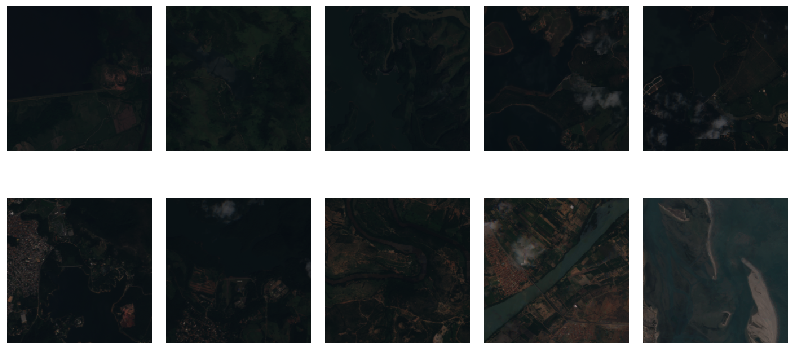

In [65]:
fig = plt.figure(figsize=(columns+8, rows+6))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.1, hspace=0.0, 
         top=1.-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.5/(columns+1)) 

parse_iter = iter(parsed_image)
print("Bad images:")
for i in range(rows):
    for j in range(columns):
        image_features = parse_iter.next()
        ax = plt.subplot(gs[i,j])
        ax.imshow(image_features)
        plt.axis('off')

The images above are still somewhat dark, and not satisfactory. Upon inspection of the TFRecord stream in the RGB channels I found that the values were somewhere between 0 and 0.02. Assuming that the color space was mapped in between \[0,1\] for all channels, this is very low, and thus it is no wonder that the images appear dark. 

In order to solve this problem we can force the images to use the entire range of possible pixel values by mapping the color space to \[0,255\] and forcing the highest pixel value to 255 itself. The way we can do this is to simply multiple each element in each color channel by 255, and dividing it by the maximum value (out of all the channels). The function that does this is implemented above in the stretch_image_colorspace function.

The results of implementing this change looks something like what is depicted below


Good images:


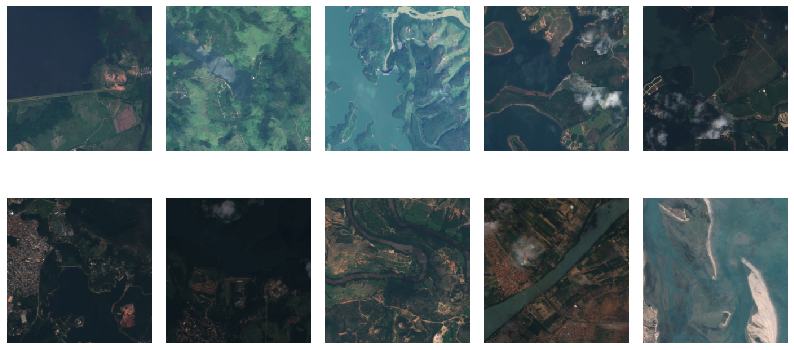

In [64]:
fig = plt.figure(figsize=(columns+8, rows+6))
# remake iterator

parse_iter = iter(parsed_image)
print("Good images:")
for i in range(rows):
    for j in range(columns):
        image_features = parse_iter.next()
        ax = plt.subplot(gs[i,j])
        ax.imshow(stretch_image_colorspace(image_features))
        plt.axis('off')